In [1]:
%config Completer.use_jedi = False
import scanpy as sc
import pandas as pd
sc.set_figure_params(dpi = 150)
from matplotlib import pyplot as plt
import seaborn as sns
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")
sns.set_palette('colorblind')

savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=300)
# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict



def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata 

    if remove_dissociation:
        dissociation_genes = pd.read_csv('../../metadata/SuppTab5_GenesAffectedByDissociation.tsv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes.iloc[:,0])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    return adata







In [2]:
tissue_colors_dictionary = tissue_colors()


cell_label = 'cell_ontology_class'


# cannot currently read this object because it kills my kernel
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')

# subset to circulating cell types
cell_types_in_Blood = adata.obs.groupby('tissue')[cell_label].value_counts().xs('Blood')
circulating_cell_types = cell_types_in_Blood[cell_types_in_Blood > 30]

adata = adata[adata.obs.cell_ontology_class.isin(circulating_cell_types.index)]


adata = adata.to_memory()


adata = _pp(adata, True, True, True)

In [3]:
# looking at specifically macrophage 
cell_type = 'macrophage'
label = 'tissue'
_sub_adata = adata[adata.obs.cell_ontology_class == cell_type]

# subset to tissues with more than 10 members of this particular cell class
_df = pd.DataFrame(_sub_adata.obs.groupby(label)[cell_label].value_counts() > 10)
_tissues = _df[_df.cell_ontology_class == True].unstack().index.to_list()
_sub_adata = _sub_adata[_sub_adata.obs.tissue.isin(_tissues)]

In [4]:
sc.tl.rank_genes_groups(_sub_adata, groupby=label, method='wilcoxon')

sc.tl.filter_rank_genes_groups(_sub_adata, min_fold_change=0.8, min_in_group_fraction=0.5)

Trying to set attribute `.uns` of view, copying.


In [5]:
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})

In [6]:
holo_gene_set = []
num_genes = 20
result = _sub_adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
gene_df = pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
     # Get Each Clusters 10 top Genes
    for group in groups for key in ['names', 'pvals']})


#iterate thru the unique tissues
for tis in _sub_adata.obs[label].unique():

    # reset rank genes df for new organ
    _gene_df = gene_df.copy()
     # Drop the filtered genes
    _gene_df = _gene_df[[tis + '_names', tis + '_pvals']].dropna()
    gene_list = _gene_df[tis + '_names'].to_list()
    genes = gene_list
    holo_gene_set.append(gene_list)
    score_name = tis + '_' + cell_type + "_residence_score"
    sc.tl.score_genes(_sub_adata, gene_list = gene_list[:num_genes], score_name = score_name, use_raw = False)
    plotdf = sc.get.obs_df(
            _sub_adata,
            keys=genes + [label, score_name])
    for gene in genes[:10]:
        g = sns.displot(data = plotdf, x = gene, hue = label, kind='ecdf', palette=tissue_colors_dictionary
                   )
        g.set_titles(cell_type)
        g.set_xlabels(gene + ' expression')
        directory = 'figures/{}_specific/{}_{}/'.format(label, cell_type, tis)
        if not os.path.exists(directory):
            os.makedirs(directory)
        g.savefig('figures/{}_specific/{}_{}/{}.pdf'.format(label, cell_type, tis, gene))
    g = sns.displot(data = plotdf, x=score_name, hue = label, kind = 'ecdf', palette=tissue_colors_dictionary )
    g.savefig('figures/{}_specific/{}.pdf'.format(label, score_name))

KeyError: "Could not find keys '['ALB', 'AREG', 'CD36', 'DDIT4', 'FAM49A', 'HES1', 'HLA-DQA1', 'HLA-DQB1', 'MXD1', 'NR4A3', 'PDE4B', 'PTGS2', 'SAA1', 'SEC14L1', 'YTHDF3']' in columns of `adata.obs` or in adata.var_names."

# Save Results

In [49]:
flat_list = [item for sublist in holo_gene_set for item in sublist]

pd.DataFrame(flat_list).to_csv(cell_type + "tissue_distinguishing_genes.csv")

## Re load the data 

In [4]:

import pandas as pd
cell_type = 'macrophage'

df = pd.read_csv(cell_type + 'tissue_distinguishing_genes.csv', index_col=0)





# PCA

In [5]:
# cannot currently read this object because it kills my kernel
cell_type = 'macrophage'
gene_set = df.iloc[:,0]
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')

adata = adata[adata.obs.cell_ontology_class == cell_type]

adata = adata.to_memory()
adata = adata[~adata.obs.tissue.isin(['Salivary_Gland', 'Heart', 'Eye'])]

subset = True 
if subset:
    adata = adata[:,adata.var.index.isin(gene_set)]

def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata 

    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    return adata

adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [55]:
_sub_adata = 0

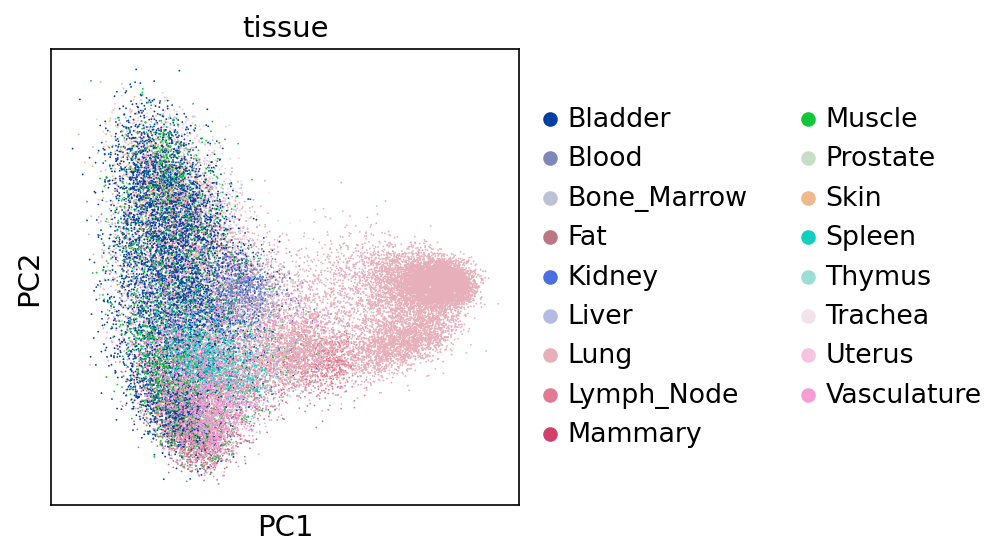

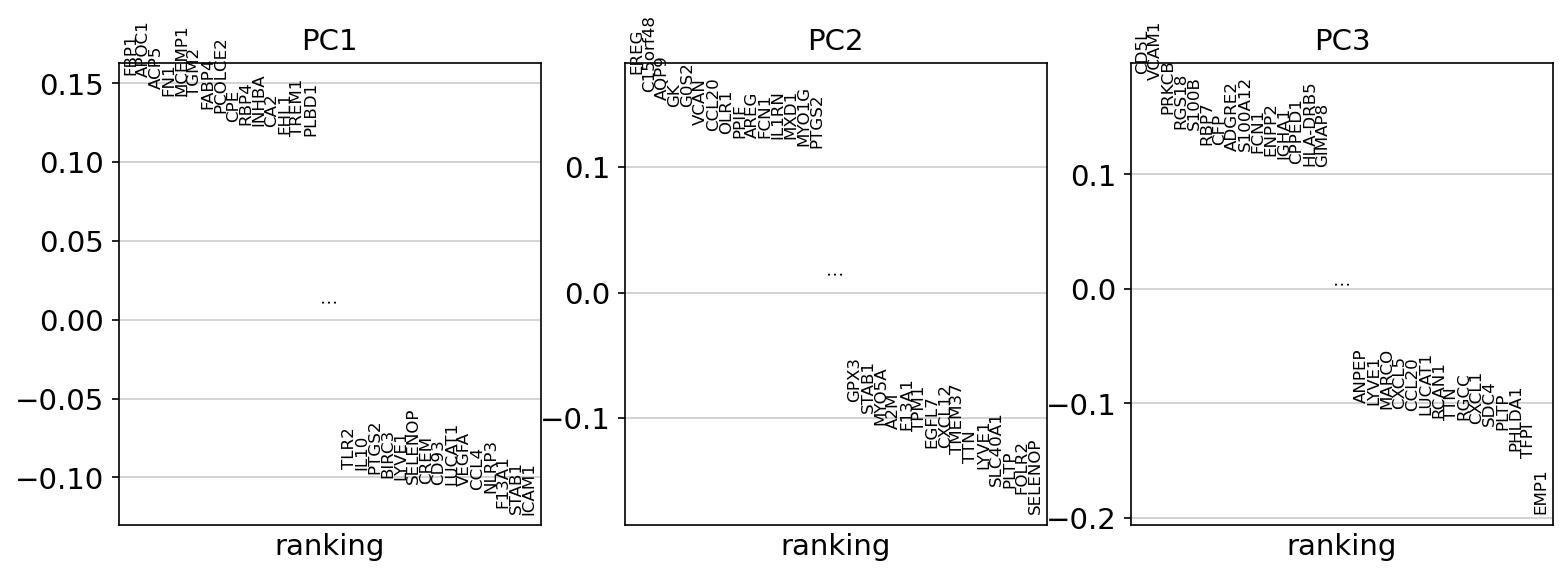

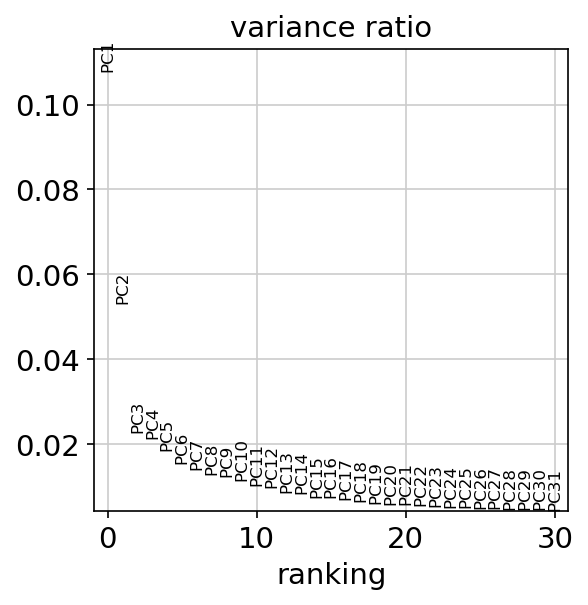

In [6]:
sc.pp.scale(adata)

sc.pp.pca(adata)

sc.pl.pca_overview(adata, color = ['tissue'], projection = '2d', size = 3)

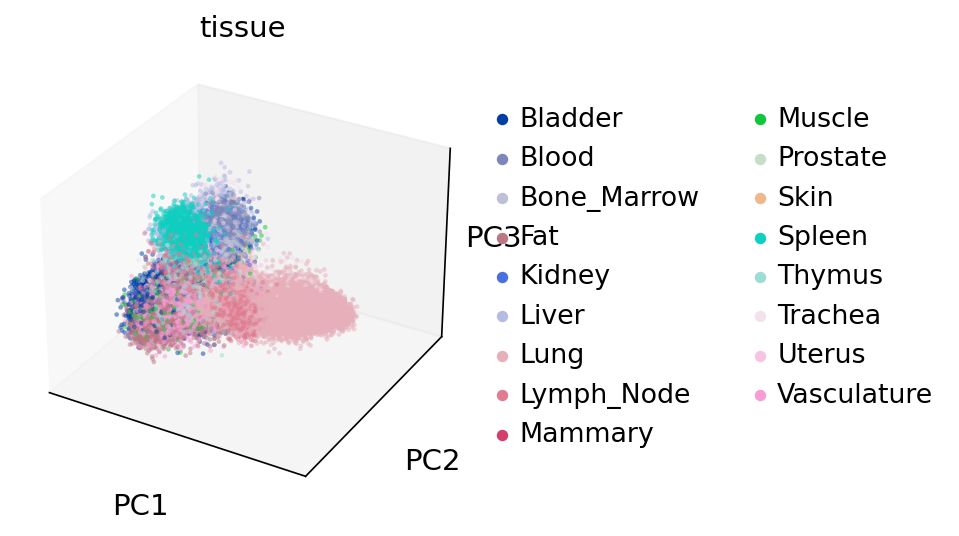

In [8]:
sc.pl.pca(adata, color = ['tissue'], add_outline=False, projection = '3d', size=60, alpha = 0.5)

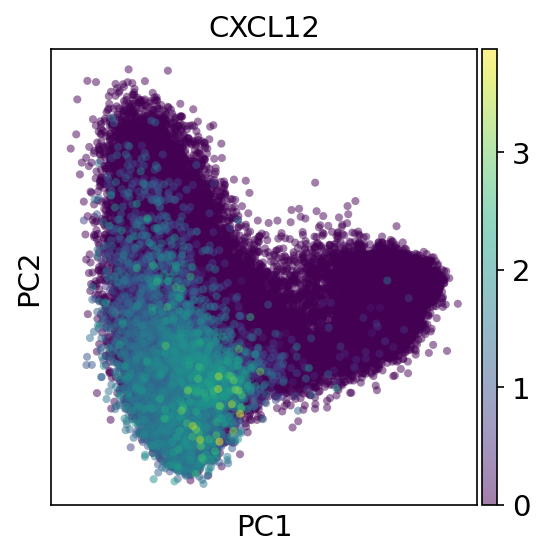

In [9]:
sc.pl.pca(adata, color = ['CXCL12'], add_outline=False, projection = '2d', size=60, alpha = 0.5)

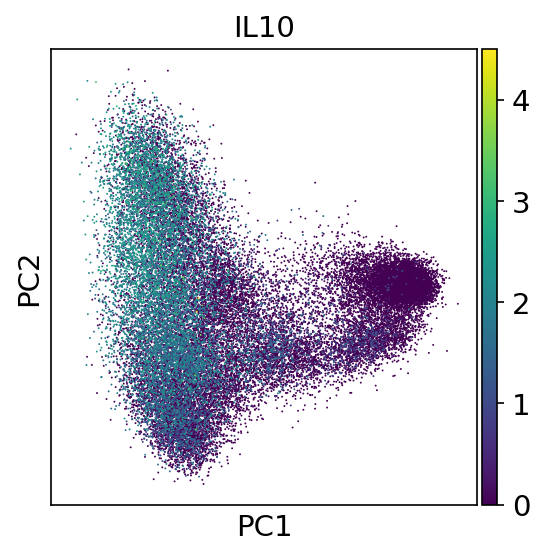

In [10]:
sc.pl.pca(adata, color = ['IL10'], add_outline=False, projection = '2d')

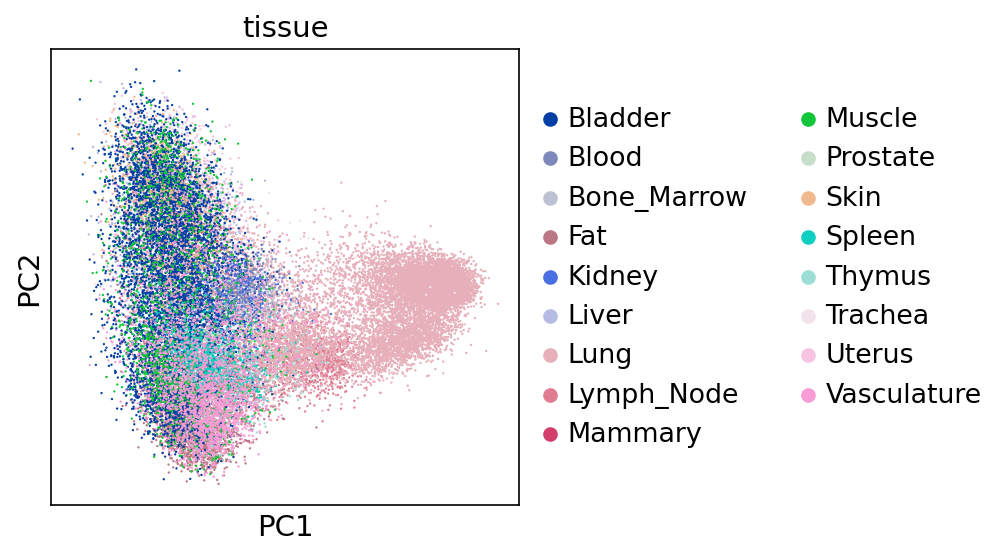

In [11]:
sc.pl.pca(adata, color = ['tissue'], add_outline=False, projection = '2d', size=5, save=
'macrophage_tissue', )

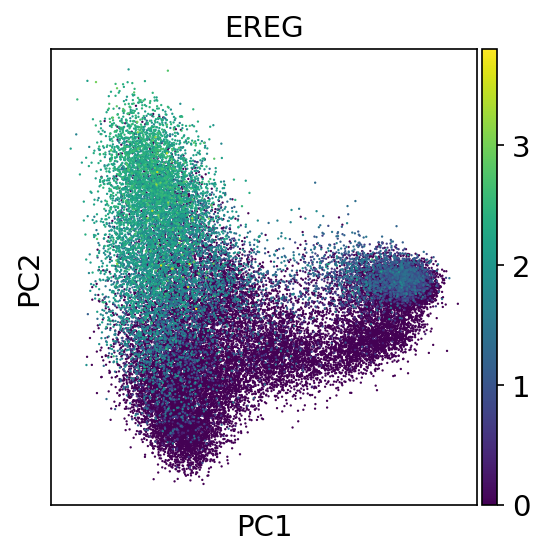

In [12]:
gene = 'EREG'
sc.pl.pca(adata, color = gene, add_outline=False, projection = '2d', size=5, save = 'macrophage'+gene)

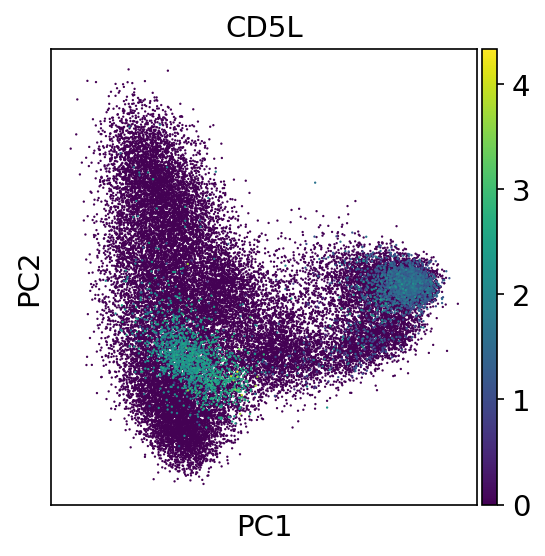

In [13]:
gene = "CD5L"
sc.pl.pca(adata, color = gene, add_outline=False, projection = '2d', size=5, save = 'macrophage'+gene)

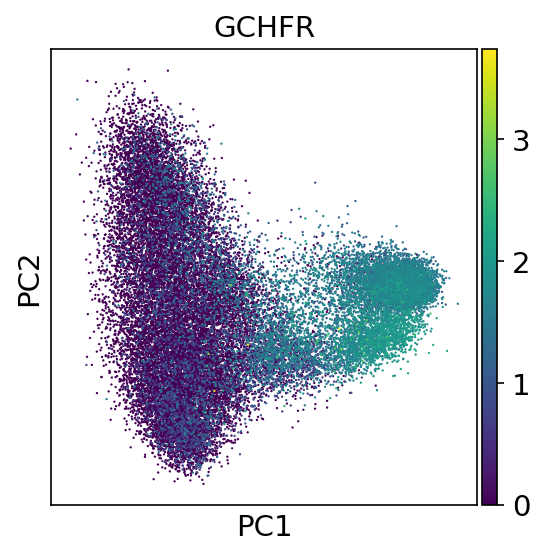

In [14]:
gene = "GCHFR"
sc.pl.pca(adata, color = gene, add_outline=False, projection = '2d', size=5, save = 'macrophage'+gene)

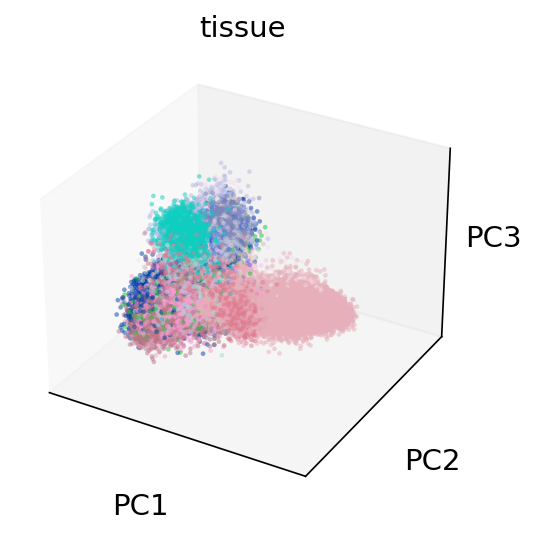

In [15]:
sc.pl.pca(adata, color = ['tissue'], add_outline=False, projection = '3d', size=60, alpha = 0.5, legend_loc=None)

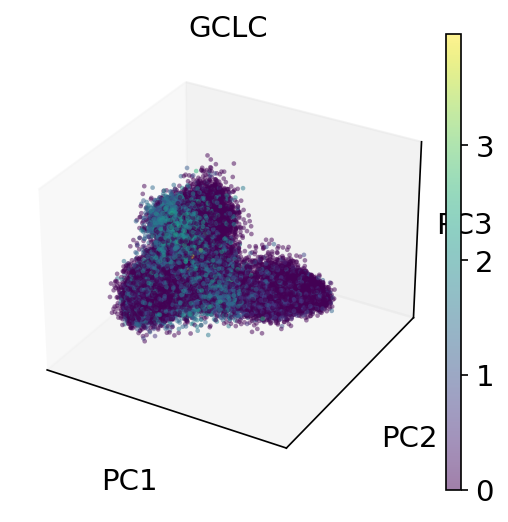

In [16]:
sc.pl.pca(adata, color = ['GCLC'], add_outline=False, projection = '3d', size=60, alpha = 0.5)

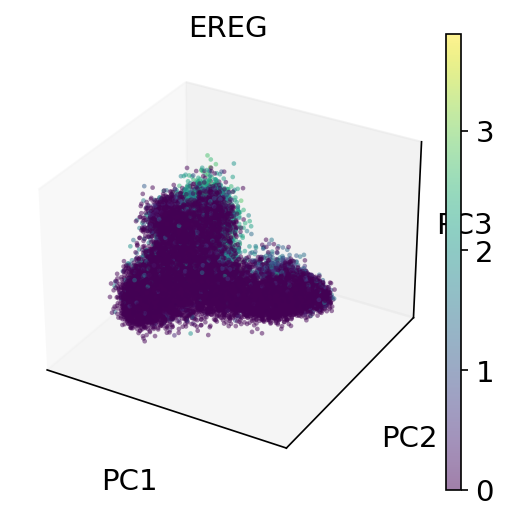

In [17]:
sc.pl.pca(adata, color = ['EREG'], add_outline=False, projection = '3d', size=60, alpha = 0.5, ncols=1)

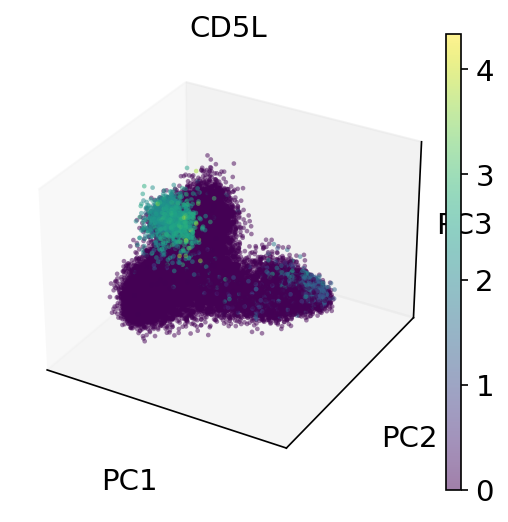

In [18]:
sc.pl.pca(adata, color = ['CD5L'], add_outline=False, projection = '3d', size=60, alpha = 0.5, ncols=1)

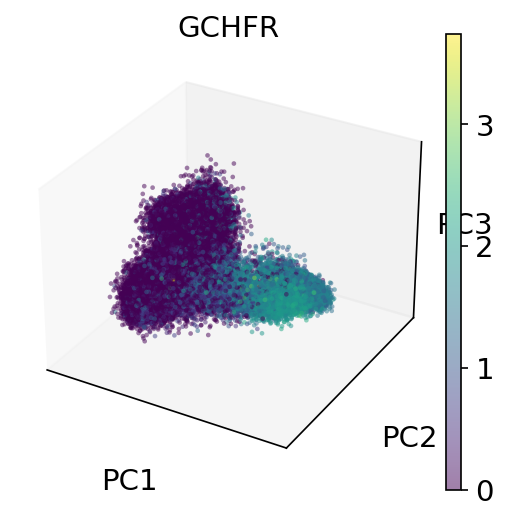

In [19]:
sc.pl.pca(adata, color = ['GCHFR'], add_outline=False, projection = '3d', size=60, alpha = 0.5, ncols=1)

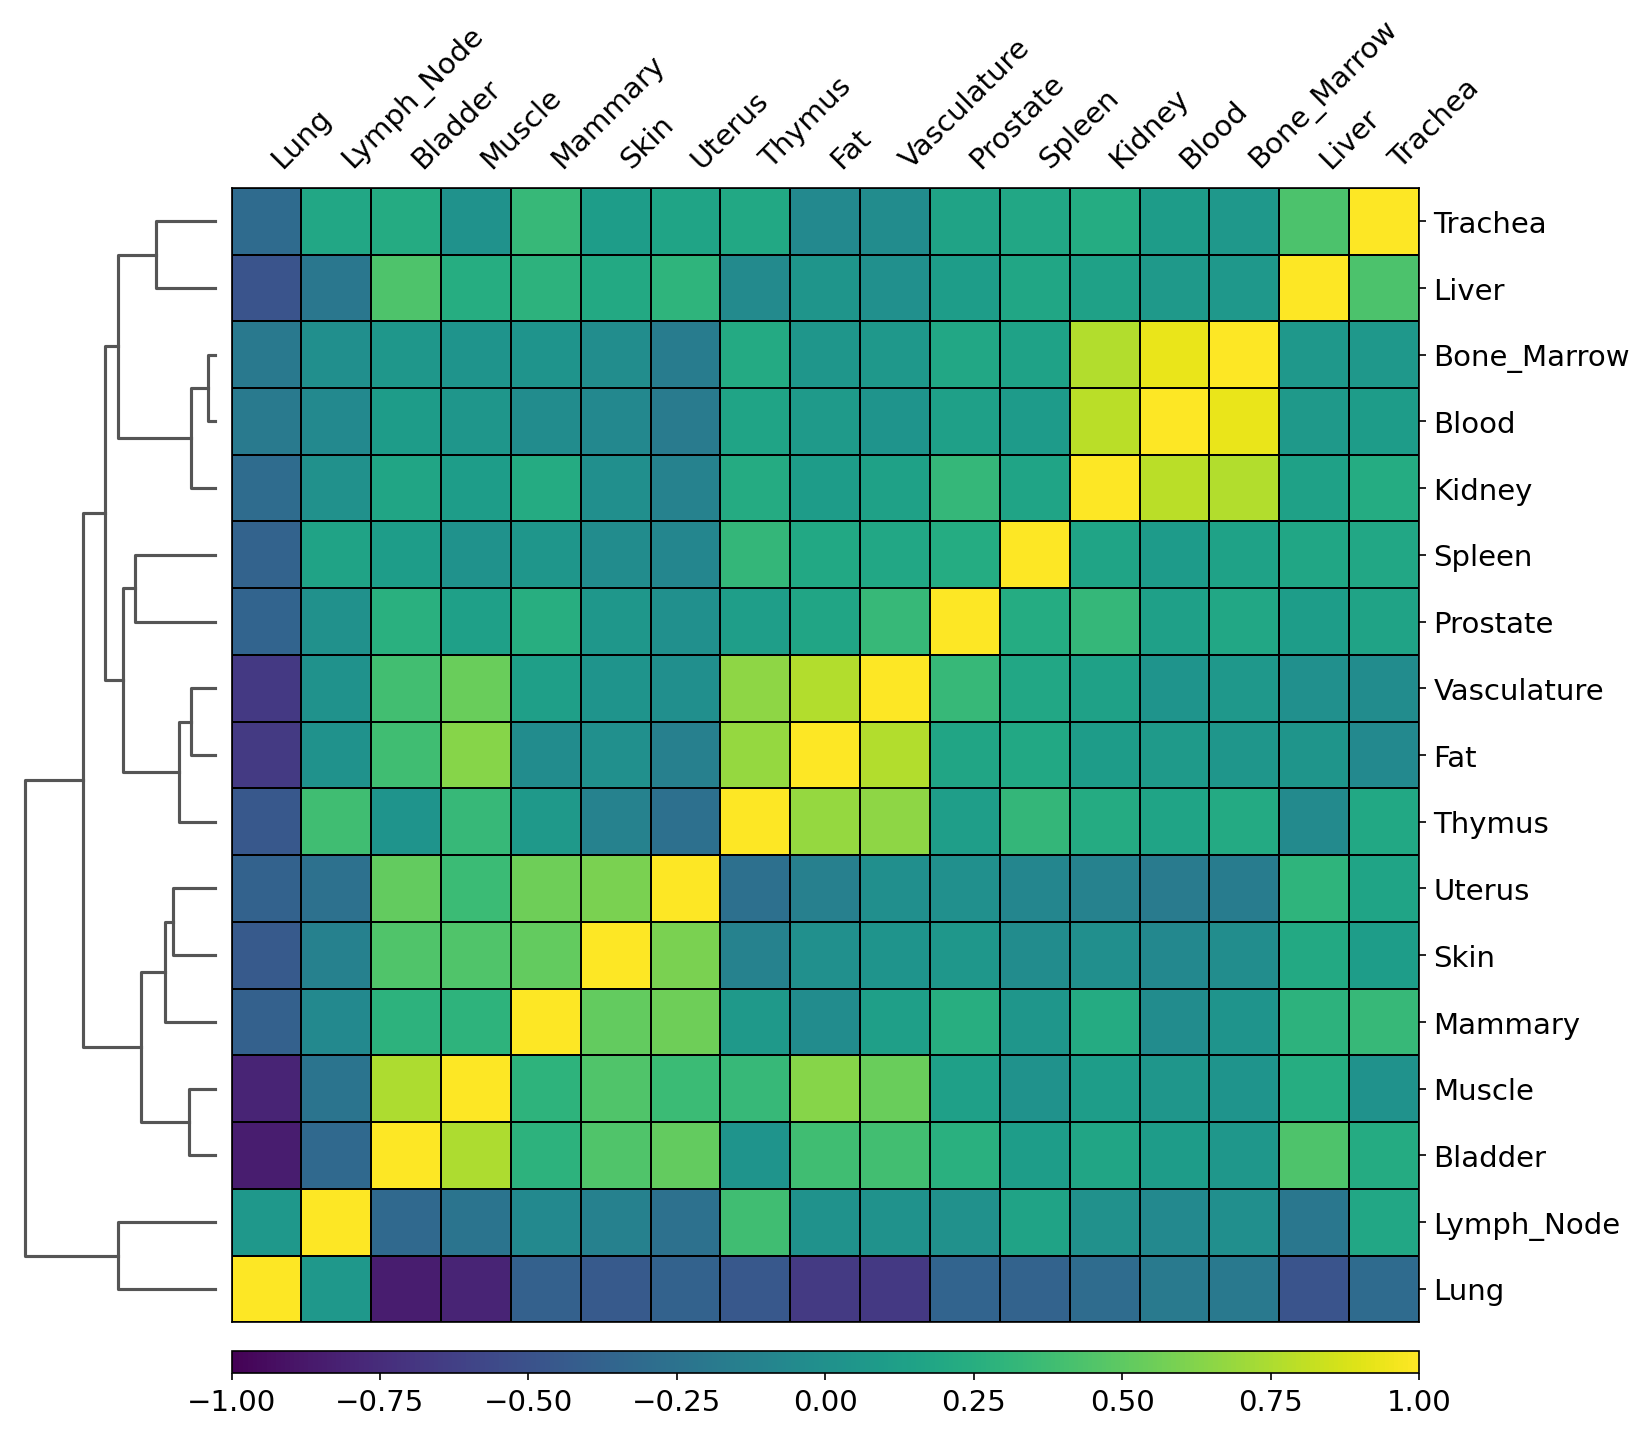

In [26]:
sc.pl.correlation_matrix(adata, groupby='tissue', cmap = 'viridis')

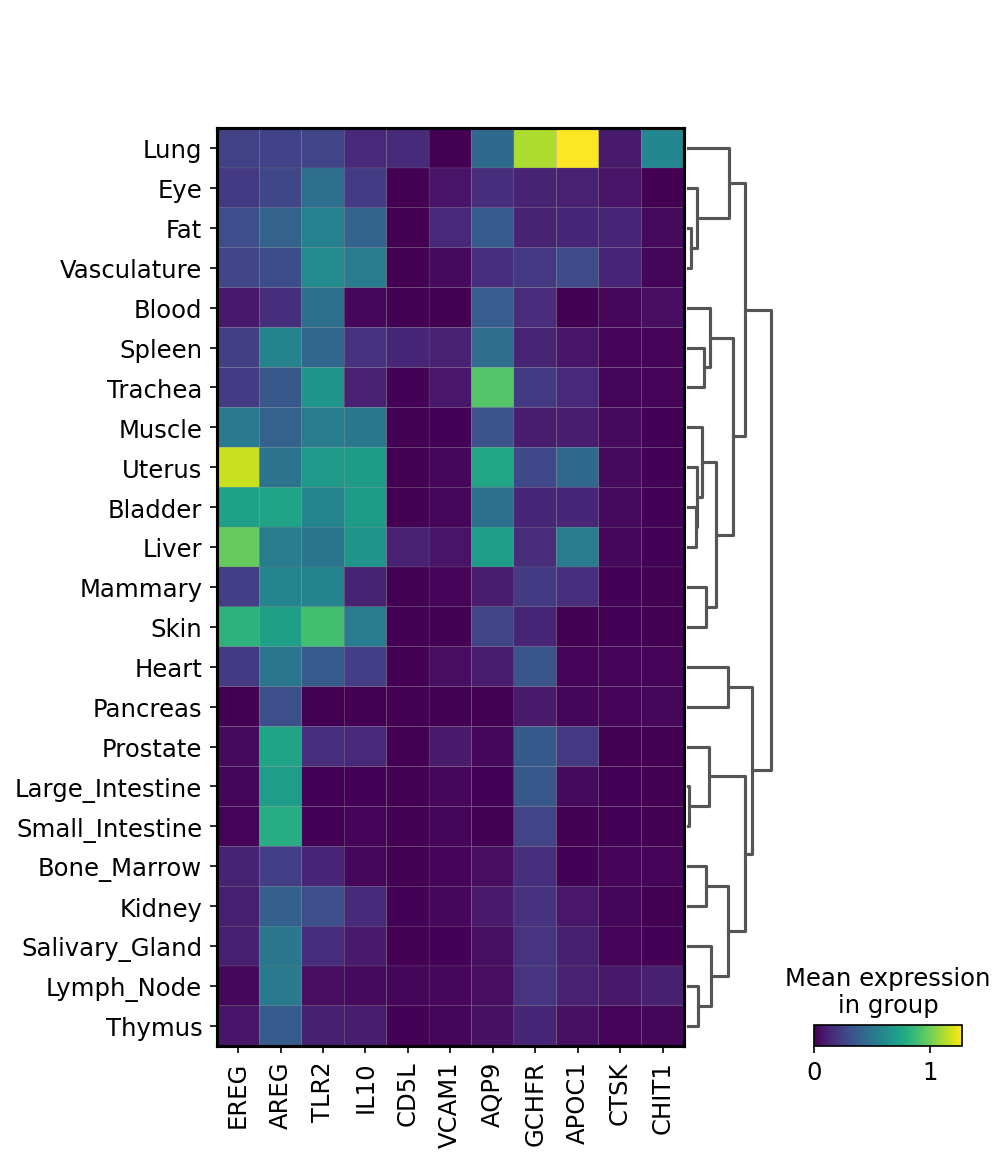

In [15]:
sc.pl.matrixplot(adata, var_names=['EREG', 'AREG', 'TLR2', "IL10", "CD5L", 'VCAM1', 'AQP9', 'GCHFR', 'APOC1', 'CTSK', 'CHIT1'], groupby='tissue', dendrogram=True)